# 11. 비교

이 장에서는 하나 이상의 변수에 대한 분포를 사용할 때 유용한 수단인 결합분포를 소개한다. 

결합분포를 사용해서 실제 문제를 풀기 전에, 우리 방식대로 먼저 우스운 문제를 풀어보자. 

우스운 문제가 무엇이냐면, 한 사람이 다른 사람보다 크다는 정보 하나만으로 두 사람의 키가 어떻게 되는지를 추정한다. 

그리고 실제 문제는 경기 결과를 기반으로 체스 선수(혹은 다른 경기 참가자)의 순위를 매긴다. 

결합분포를 만들고 이 문제의 가능도를 구하는 데는 외적 및 비슷한 연산을 사용한다. 그럼 이 연산부터 살펴보도록 하자. 


## 11.1 외적 연산

두 수열의 '외적'(outer product)을 사용하면 많은 유용한 연산을 할 수 있다. 다음과 같이 x와 y의 두 수열이 있다고 하자. 

In [1]:
x = [1,3,5]
y = [2,4]

이 수열의 외적은 각 수열의 값의 모든 쌍의 곱으로 이루어진 배열이다. 외적을 구하는 방법에는 여러 가지가 있으나, 가장 다용도로 사용되는 것은 mesh grid 다. 

넘파이에는 메쉬 그리드를 구하는 meshgrid()라는 함수가 있다. 이 함수에 수열 두 개를 넣으면, 두 개의 배열을 반환한다. 

In [2]:
import numpy as np

X,Y = np.meshgrid(x,y)

첫 배열은 x를 행으로 복사해서 넣는다. 이 때 행의 수는 y의 길이와 같다.

In [3]:
X

array([[1, 3, 5],
       [1, 3, 5]])

두 번째 배열은 y를 열로 복사해서 넣는다. 이 때 열의 수는 x의 길이다. 

In [4]:
Y

array([[2, 2, 2],
       [4, 4, 4]])

두 배열은 크기가 같으므로, 곱셈같은 수학연산을 적용할 수 있다.

In [5]:
X*Y

array([[ 2,  6, 10],
       [ 4, 12, 20]])

이 결과는 x와 y의 외적이다. 이 값을 데이터프레임에 넣으면 보다 확실하게 이해할 수 있다.

In [6]:
import pandas as pd

df = pd.DataFrame(X*Y, columns = x, index = y)
df

,1,3,5
2,2,6,10
4,4,12,20


x의 값이 열 이름으로 나오고 y의 값이 행 이름으로 나왔다. 각각의 값은 x의 한 개의 값과 y의 한 개의 값의 곱이다. 

메쉬 그리드를 사용해서 x의 각 원소와 y의 각 원소의 합을 갖는 배열을 만드는 외적 합 같은 다른 연산도 할 수 있다. 

In [7]:
X+Y

array([[3, 5, 7],
       [5, 7, 9]])

In [8]:
X>Y

array([[False,  True,  True],
       [False, False,  True]])

이 연산자를 사용하는 게 유용한지 아직은 잘 모르겠지만, 예제를 접하면 알게 된다. 

이 연산자를 사용해서 새로운 베이지안 문제를 풀어보자. 

## 11.2 A의 키는 얼마인가?

미국의 성인 남성 중 두 명을 임의로 골랐다고 하자. 이 둘을 A와 B로 부른다. 만약 A가 B보다 큰 것 같을 때, A의 키는 얼마인가?

이 문제를 풀려면 다음과 같은 단계가 필요하다.

1. 키에 대한 사전분포를 만들기 위해 미국 남성의 키에 대한 배경지식을 사용한다. 
2. A와 B에 대한 키의 사전결합분포를 만든다. (그리고 이에 대해 설명함)
3. A가 더 크다는 정보를 이용해 사전분포를 갱신한다.
4. 사후결합분포에서 A의 키의 사후분포를 가져온다. 

미국 성인 남성의 키는 178cm이고, 표준편차는 7.7cm 이다. 키의 분포는 정확히 정규분포를 따르지는 않는데, 정규 분포는 실제 분포에 대한 꽤 좋은 모델이므로 여기서는 일단 키의 사전분포를 모델링하는 데 사용한다. 

다음은 평균에서 위 아래로 3 표준편차까지의 구간에 동일한 간격을 둔 배열이다.

In [9]:
mean = 178

qs = np.arange(mean - 24, mean + 24, 0.5)

from scipy.stats import norm

std = 7.7
ps = norm(mean, std).pdf(qs)

from empiricaldist import Pmf

prior = Pmf(ps, qs)
prior.normalize()

1.9963309462450582

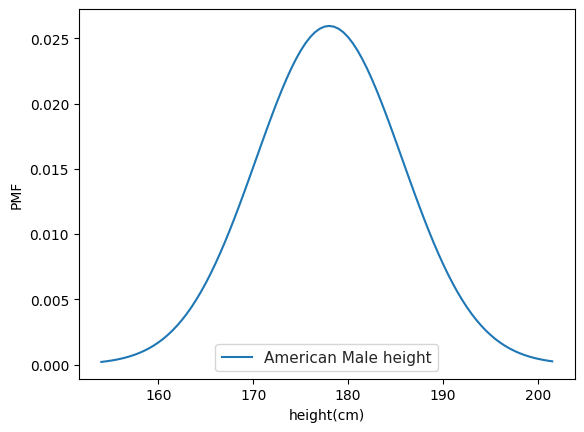

In [10]:
from utils import plt_default
prior.plot(label = 'American Male height')
plt_default('height(cm)')

이 분포는 A가 B보다 크다는 데이터를 접하기 전에 A와 B의 키에 대한 믿음을 나타낸다. 

## 11.3 결합분포

다음 단계는 키의 모든 쌍에 대한 확률을 나타내는 분포인 결합분포를 만드는 것이다. 결합분포의 원소는 다음과 같이 표기한다. 

$$ P(A_{x} and B_{y})$$

이 값은 모든 x와 y에 대해 A의 키가 x cm이고 B의 키가 y cm일 확률을 나타낸다. 

지금까지 우리가 알고 있는 전부는 A와 B가 남성인 미국 거주자라는 것뿐이므로 이 둘의 키는 서로 독립적이다. 즉 A의 키에 대해서 안다고 해도 이 정보가 B의 키를 파악하는 데 어떤 도움도 되지 않는다. 

이 경우 결합확률은 독립이므로 이렇게 나타난다. 

$$ P(A_{x} and B_{y}) = P(A_{x})P(B_{y})$$

각 결합분포는 x의 분포중의 한 원소와 y의 분포 중 한 원소 간의 곱이다. 

따라서 A와 B의 키의 분포를 나타내는 Pmf 객체가 있다면 각 Pmf의 확률의 외적을 구함으로써 결합분포를 만들 수 있다. 

다음 함수는 두 개의 Pmf 객체를 취해서 결합분포를 나타내는 데이터프레임을 만든다. 

In [11]:
def make_joint(pmf1:Pmf, pmf2:Pmf)->pd.DataFrame:
    """Compute outer product of two Pmf instance"""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X*Y, columns = pmf1.qs, index = pmf2.qs)

결과값의 열의 이름은 pmf1의 값이고, 행의 이름은 pmf2의 값이다. 

이 예제에서 A와 B의 사전분포는 동일하므로 다음과 같이 구할 수 있다.

In [12]:
joint = make_joint(prior, prior)
joint.shape

(96, 96)

이 결과값으로 열 이름에 A의 가능한 키가 들어가고, 인덱스에 B의 가능한 키가 들어간다. 

원소로는 각 값의 결합확률이 들어간 데이터프레임이 나온다. 

사전분포가 정규화되어 있다면, 사전결합분포 역시 정규화되어 있다. 

모든 원소의 값을 더하려면 sum()을 호출하기 전에 데이터프레임을 넘파이 배열로 변환해야 한다. 

Dataframe.sum()은 열의 값을 구한 후 시리즈 형태의 결괏값을 반환한다. 

## 11.4 결합분포 시각화

다음 함수는 pcolormesh()를 사용해서 결합분포의 그래프를 그린다. 

In [13]:
import matplotlib.pyplot as plt

def plot_joint(joint, cmap = 'Blues'):
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint,
                   cmap = cmap, 
                   vmax = vmax,
                   shading = 'nearest')
    plt.colorbar()

    plt.xlabel('A height in cm')
    plt.ylabel('B height in cm')
    plt.legend()
    plt.show()    

In [14]:
import matplotlib.pyplot as plt
from utils import decorate

def plot_joint(joint, cmap = 'Blues'):
    vmax = joint.to_numpy().max() * 1.1
    plt.pcolormesh(joint.columns, joint.index, joint,
                   cmap = cmap, 
                   vmax = vmax,
                   shading = 'nearest')
    plt.colorbar()
    decorate(xlabel = 'A height in cm',
            ylabel = 'B height in cm')

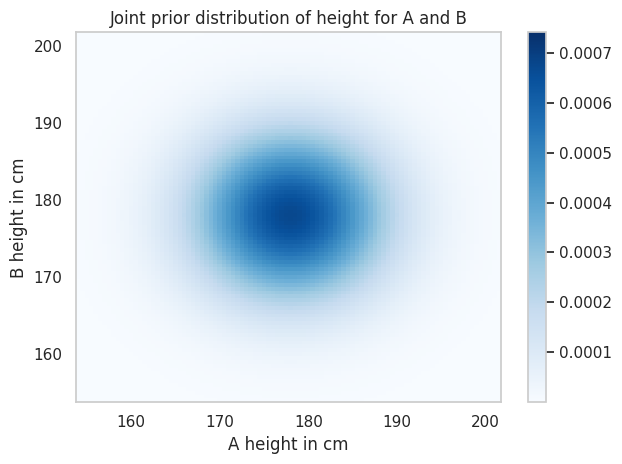

In [15]:
plot_joint(joint)
decorate(title = 'Joint prior distribution of height for A and B')

예상했겠지만, 확률은 평균 키 부근에서 가장 높고 평균에서 멀어질 수록 낮아진다. 

결합분포를 나타내는 다른 방법으로는 등고선 형태로 나타내는 방법이 있다.

In [16]:
def plot_contour(joint):
    """결합분포를 등고선 그래프로 그림"""
    plt.contour(joint.columns, joint.index, joint, 
                linewidths = 2)
    decorate(xlabel = 'A height in cm',
            ylabel = 'B height in cm')

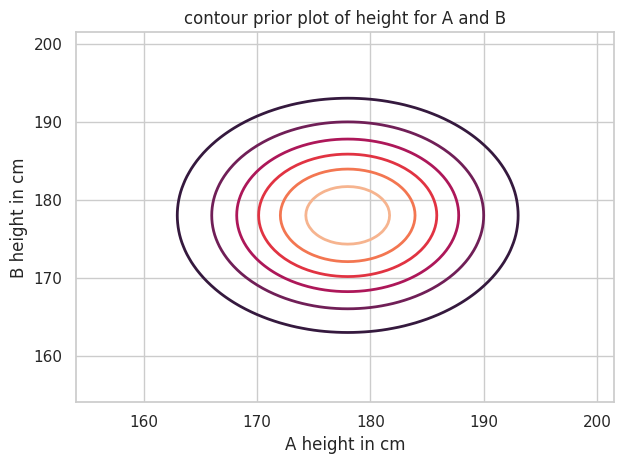

In [18]:
plot_contour(joint)
decorate(title = 'contour prior plot of height for A and B')

## Likelihood

사전결합분포가 마련되었으니, 여기에 A가 B보다 크다는 데이터를 사용해서 갱신할 수 있다. 

결합분포의 각 원소는 A와 B의 키에 대한 가설을 의미한다. 키에 대한 모든 쌍의 가능도를 계산하려면 다음과 같이 열의 이름과 행의 라벨을 사전분포에서 추출할 수 있다.

In [19]:
x = joint.columns
y = joint.index
# 이렇게 구한 값으로 메쉬 그리드를 만든다.
X,Y = np.meshgrid(x,y)

X에는 A의 가능한 키의 값인 x의 값이 복사되어 들어있고, Y에는 y에 있는 B의 가능한 키 값이 들어있다. 

X와 Y를 비교하게 되면, 그 결괏값은 불리언 배열이 된다. 

In [20]:
X

array([[154. , 154.5, 155. , ..., 200.5, 201. , 201.5],
       [154. , 154.5, 155. , ..., 200.5, 201. , 201.5],
       [154. , 154.5, 155. , ..., 200.5, 201. , 201.5],
       ...,
       [154. , 154.5, 155. , ..., 200.5, 201. , 201.5],
       [154. , 154.5, 155. , ..., 200.5, 201. , 201.5],
       [154. , 154.5, 155. , ..., 200.5, 201. , 201.5]])

In [21]:
A_taller = (X>Y)

여기서는 np.where()을 사용해서 A_taller가 True인 경우 1이 되고 아닌 경우 0이 되는 배열을 만든 후 이를 사용해서 가능도를 구한다. 

x의 값을 열 이름으로 놓고 y의 값을 행 이름으로 놓은 데이터프레임을 만들어 이 가능도 배열을 시각화 한다. 

이 데이터의 가능도는 X>Y인 경우 1이고, 아닌 경우 0이다. 

In [23]:
a = np.where(A_taller, 1, 0)
likelihood = pd.DataFrame(a, index = x, columns = y)

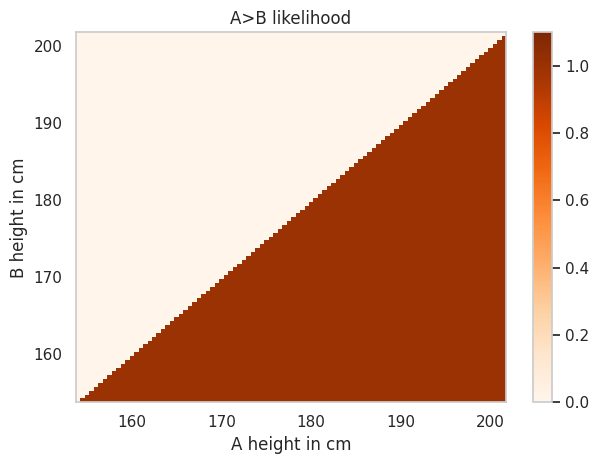

In [25]:
plot_joint(likelihood, cmap = 'Oranges')
decorate(title = 'A>B likelihood')

## 11.6 갱신

사전분포도 있고 가능도도 있으니, 이제 사후분포를 업데이트할 시간이다. unnormalized 사후분포는 여태까지와 똑같이 사전분포와 가능도의 곱으로 구현된다. 

In [27]:
posterior = joint * likelihood

In [28]:
def normalize(joint):
    """결합분포 정규화"""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

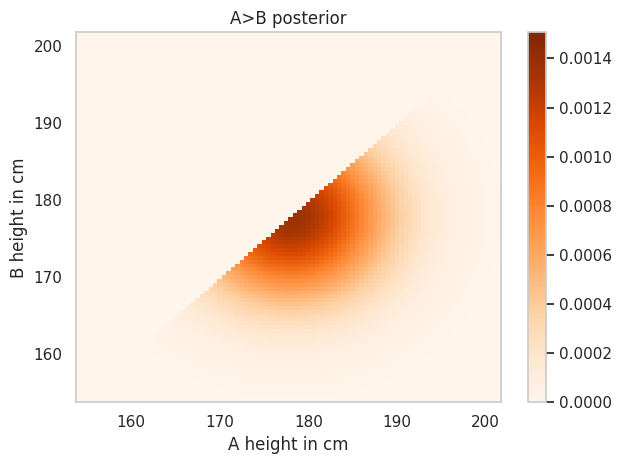

In [29]:
normalize(posterior)
plot_joint(posterior, cmap = 'Oranges')
decorate(title = 'A>B posterior')

B가 A보다 큰 경우에 해당하는 prior의 모든 쌍이 제거되었다.

남은 사후확률은 재정규화되었다는 것을 제외하면 사전분포(prior)와 동일하게 생겼다. 

## 11.7 주변분포

사후결합분포는 주어진 사전분포와 A가 더 크다는 정보하에서 A와 B의 키에 대한 믿음(believe)이 어떤지를 보여준다. 

이 결합분포로부터 A와 B의 사후분포를 구할 수 있다. 어떻게 하는지는 다음의 간단한 문제를 풀면서 살펴보자. 

A가 180cm일 확률을 알아보고자 한다 하자. 그럼 우선 이 결합분포에서 x=180인 열을 선택한다.

In [30]:
column = posterior[180]
column.head()

154.0    0.000010
154.5    0.000013
155.0    0.000015
155.5    0.000019
156.0    0.000022
Name: 180.0, dtype: float64

이 열에는 x = 180 일 때의 모든 경우에 대한 사후확률값이 들어있다. (즉 A는 180일 때의 B의 키에 대한 확률)

이 값을 다 더하면 A의 키가 180cm일 때의 총 확률이 나올 것이다.

In [31]:
column.sum()

0.03017221271570807

약 3% 정도 된다. 

그럼 A의 사후확률분포를 구하려면 다음과 같이 각 열을 모두 더하면 된다.

In [32]:
columns_sums = posterior.sum(axis = 0)
columns_sums.head()

154.0    0.000000e+00
154.5    1.012260e-07
155.0    2.736152e-07
155.5    5.532519e-07
156.0    9.915650e-07
dtype: float64

axis = 0 인자는 열 기준으로 더하고 싶다는 뜻이다. 이렇게 결과는 A의 모든 가능한 키에 대한 확률을 가지는 시리즈 형태로 나타난다. 

즉 이 객체는 A의 키의 분포다. 이 값을 다음과 같이 Pmf에 담아보자.

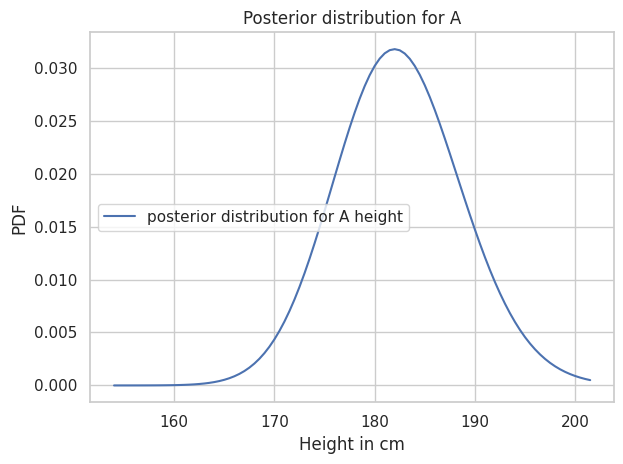

In [33]:
marginal_A = Pmf(columns_sums)
marginal_A.plot(label = 'posterior distribution for A height')
decorate(xlabel = 'Height in cm', ylabel = 'PDF', title = 'Posterior distribution for A')

이는 주변분포(marginal distribution)이라고 하고, 결합분포로부터 단일 변수의 분포를 가져오는 경우를 말한다. 

이 이름은 보통 가운데에 결합분포를 나타내고 주변에 주변분포를 나타내는 일반적인 시각화 기법에서 가지고 왔다. 

비슷한 방식으로, B의 주변분포를 구하려면 이처럼 하면 된다.

In [35]:
row_sums = posterior.sum(axis= 1)
marginal_B = Pmf(row_sums)

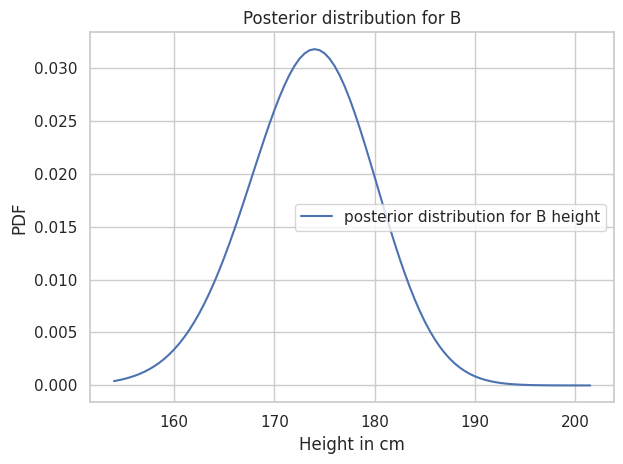

In [36]:
marginal_B.plot(label = 'posterior distribution for B height')
decorate(xlabel = 'Height in cm', ylabel = 'PDF', title = 'Posterior distribution for B')

In [34]:
def marginal(joint:pd.DataFrame, axis=0)->Pmf:
    """주변분포를 구함"""
    return Pmf(joint.sum(axis = axis))

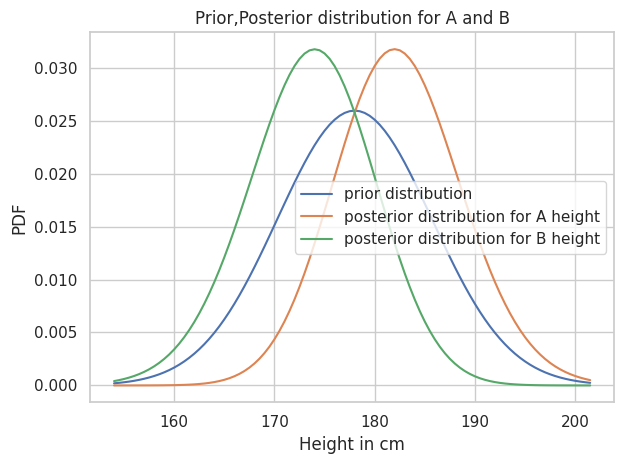

In [37]:
prior.plot(label = 'prior distribution')
marginal_A.plot(label = 'posterior distribution for A height')
marginal_B.plot(label = 'posterior distribution for B height')
decorate(xlabel = 'Height in cm', ylabel = 'PDF', title = 'Prior,Posterior distribution for A and B')

## 11.8 사후조건부 확률

A의 키를 잰 후 키가 170cm 임을 알게 되었다고 하자. 그러면 B에 대해서 어떤 말을 할 수 있을까?

결합분포에서 각 열은 A의 가능한 키 값이다. 다음과 같이 170cm에 해당하는 열을 선택한다. 

In [38]:
column_170 = posterior[170]

이 결과는 A가 주어졌을 때의 B의 가능한 키와 이 키에 해당하는 가능도를 나타내는 시리즈다. 이 가능도는 정규화되지 않았으므로 다음과 같이 정규화할 수 있다.

In [42]:
cond_B = Pmf(column_170)
cond_B.normalize()

0.004358061205454471

Pmf를 만들면 기본적으로 데이터를 복사하므로 column_170 이나 posterior에 아무런 영향을 주지 않고 cond_B를 정규화할 수 있다.

이 결과는 A의 키가 170cm 라는 정보가 주어졌을 때의 B의 키에 대한 조건부확률분포다.

<Axes: >

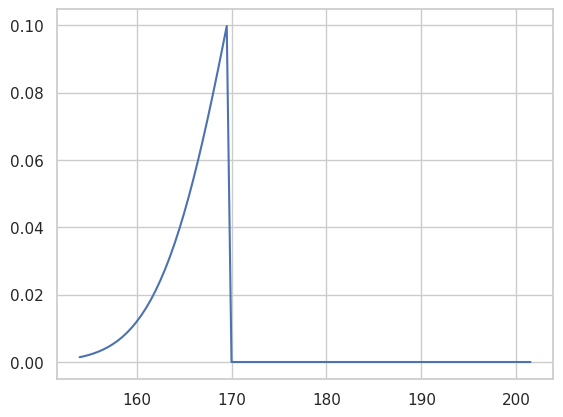

In [43]:
cond_B.plot()

170 에서 잘려나가있다. 이미 우리는 B가 A보다 작고 A가 170cm 라는 사실을 알고 있기 떄문이다.

## 11.9 Dependency and Independency

사전결합분포를 만들 때, A와 B의 키는 독립적이라고 언급했다. 이는 상호간에 영향이 없다는 말이다. 

하지만 사후분포의 경우 A와 B는 독립적이지 않다. 우리가 알고 있는 사실, A > B라는 사실과 A의 키가 얼마인지 안다는 사실은 B의 키에 대한 정보가 된다. 

앞서 구한 조건부확률분포를 통해 이런 의존성을 파악할 수 있다.

## 11.10 Summary

이 장에서는 결합분포를 구하는 데 사용한 외적 곱 같은 '외적'연산을 익히는 것에서부터 시작했다.

일반적으로는 두 개의 주변분포로부터 결합분포를 만들 수 없지만, 두 분포가 독립적인 경우에는 가능하다. 

베이지안 갱신 과정을 확장해서 여기에 결합분포를 적용해 보았다. 그리고 사후결합분포로부터 사후주변분포와 사후조건부분포를 만들어냈다.

연습 문제에서는 이 장의 내용과 동일한 과정을 조금 더 어렵지만 훨씬 실전적인 문제인 경기 결과를 사용해서 체스 선수의 순위를 갱신하는 문제를 풀면서 동일한 과정을 적용할 기회를 얻을 것이다.


## 11.11 연습 문제

### 문제 11.1

전 예제의 결과를 기반으로, B가 180cm 라고 했을 때 A의 사후조건부확률분포를 구하라.

In [44]:
# 연습이니까, 처음부터 해보자.

# 1. 사전분포
mean = 178
qs = np.arange(mean - 24, mean + 24, 0.5)
std = 7.7
ps = norm(mean, std).pdf(qs)

prior = Pmf(ps, qs)
prior.normalize() 

# 2. 사전결합분포 

def make_joint(pmf1, pmf2):
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X*Y,columns = pmf1.qs, index = pmf2.qs)

joint = make_joint(prior, prior)


# 3. 가능도
x = joint.columns
y = joint.index

X, Y = np.meshgrid(x,y)

A_taller = (X > Y) # A > B
a = np.where(A_taller, 1, 0)
likelihood = pd.DataFrame(a, columns = x, index = y)

# 4. 사후결합분포

posterior = joint * likelihood
normalize(posterior)

# 5. marginal distribution for A

columns_sums = posterior.sum(axis = 0)
marginal_A = Pmf(columns_sums)

print(marginal_A.head())

154.0    0.000000e+00
154.5    1.012260e-07
155.0    2.736152e-07
dtype: float64


cond A mean:185.59735919788176, cond A std: 4.146573350422435


<Axes: >

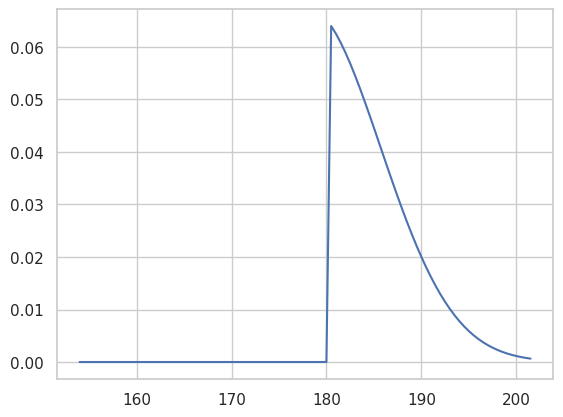

In [45]:
# 6. posterior marginal distribution for A if B = 180

row_180 = posterior.loc[180, :]

cond_A = Pmf(row_180)
cond_A.normalize()

print(f'cond A mean:{cond_A.mean()}, cond A std: {cond_A.std()}')

cond_A.plot()

#### 풀이

요약하면 간단하다.

1. 사전분포를 구한다.
2. meshgrid 를 통해 사전결합분포를 구한다.
3. likelihood 를 구한다. 
4. 사전결합분포에 likelihood를 곱하고 normalize 해서 사후결합분포를 구한다.
5. 사후결합분포의 조건에 해당하는 행 또는 열을 탐색한다. 이 행 or 열이 조건부사후결합분포가 된다. 

### 문제 11.2

A가 B보다 크다는 것이 확실하다는 것을 알게 되었지만, B가 얼마나 큰 지는 모른다고 하자. 

이 때 임의의 여성 C가 나타났고, C는 A보다 15cm 이상 작다는 사실을 알게 되었다. 이 때 A와 C의 키의 사후분포를 구해보자. 

미국 평균 여성 신장은 163cm고, 표준편차는 7.3cm 이다. 

(88, 96)


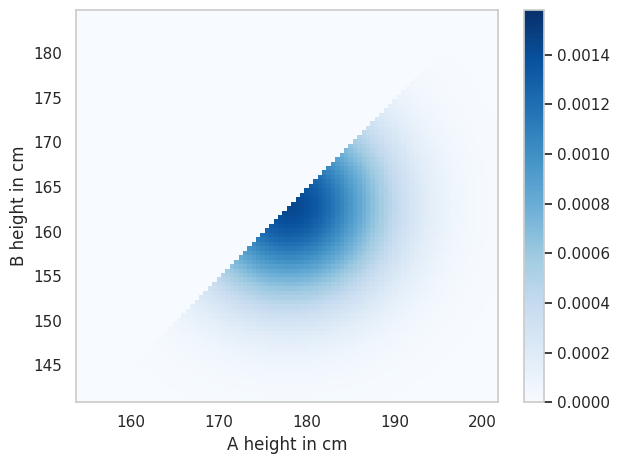

In [47]:
# 미국 평균 여성 C의 사전분포
mean_female = 163
std_female = 7.3
qs = np.arange(mean_female - 3*std_female,mean_female + 3*std_female, 0.5)
ps = norm(mean_female,std_female).pdf(qs)
prior_female = Pmf(ps, qs)
prior_female.normalize()

# joint prior
joint_mf = make_joint(prior, prior_female)

print(joint_mf.shape)

# likelihood = P(A|A > C + 15)
x = joint_mf.columns
y = joint_mf.index
X,Y = np.meshgrid(x,y)
likelihood = pd.DataFrame(np.where(X>(Y+15), 1, 0), columns = x, index = y)

# posterior
posterior = joint_mf * likelihood
normalize(posterior)

plot_joint(posterior)

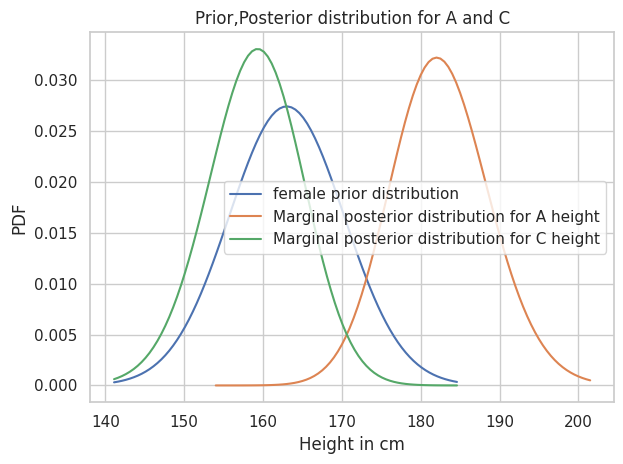

In [50]:
marginal_A = marginal(posterior, axis = 0)
marginal_C = marginal(posterior, axis = 1)

prior_female.plot(label = 'female prior distribution')
marginal_A.plot(label = 'Marginal posterior distribution for A height')
marginal_C.plot(label = 'Marginal posterior distribution for C height')
decorate(xlabel = 'Height in cm', ylabel = 'PDF', title = 'Prior,Posterior distribution for A and C')

## 문제 11.3 

ELO 평점시스템은 체스 같은 경기에서 선수들의 기술 등급을 수치화하는 한 가지 방법이다. 

이 시스템은 선수들의 평점과 경기 결과간의 관계를 모델링한 것이다. 좀 더 상세히 살펴보면, $R_{A}$가 A의 평점이고 $R_{B}$가 B의 평점이라고 했을 때 A가 B를 이길 확률은 로지스틱 함수 형태로 만들 수 있다. 

$$P(A \text{ beats } B) = \frac{1}{1+10^{(R_{B}-R_{A})/400}}$$

인수 10과 400은 평점 범위를 결정하기 위해 임의로 선택한 값이다. 체스의 경우 범위는 100에서 2800까지다. 

이길 확률은 단순히 순위 차이에 따라 달라진다고 하자. 예를 들어 만약 $R_{A}$ 가 $R_{B}$보다 100점 높다면 A가 이길 확률은 다음과 같다.

In [51]:
1/(1+10**(-100/400))

0.6400649998028851

A는 현재 평점이 1,600점이지만 정확한지는 모른다. 우리의 불확실성에 따라 실제 평점은 1,600에 표준편차 100인 정규분포로 나타낼 수 있다.

B는 현재 평점은 동일한 불확실 정도로, 현재 평점은 1,800점이다. 

그러면 A와 B가 경기했을 때, 평점을 어떻게 갱신해야 할까? 

In [52]:
# 사전분포 형성
mean_A = 1600
mean_B = 1800
std = 100

qs_a = np.arange(mean_A - 3*std, mean_A + 3*std, 10)
qs_b = np.arange(mean_B - 3*std, mean_B + 3*std, 10)
ps_a = norm(mean_A, std).pdf(qs_a)
ps_b = norm(mean_B, std).pdf(qs_b)
prior_A = Pmf(ps_a, qs_a)
prior_B = Pmf(ps_b, qs_b)

# 사전결합분포 생성
joint_AB = make_joint(prior_A,prior_B)

# likelihood A win
x,y = joint_AB.columns, joint_AB.index
X,Y = np.meshgrid(x,y)
diff = X - Y
a = 1 / (1 + 10**(-diff/400))
likelihood_elo = pd.DataFrame(a, columns=x, index=y)

# posterior
posterior_elo = joint_AB * likelihood_elo
normalize(posterior_elo)


# marginal

marginal_A_elo = marginal(posterior_elo, axis=0)
marginal_B_elo = marginal(posterior_elo, axis=1)

In [53]:
marginal_A_elo.mean()

1636.6483455282362